Agent lives from 0 to $T$. At each period, her consumption is $c_t$, income is $y_t$, wealth is $w_t$. After she dies, she leaves a bequest of $w_{T+1}$. Her lifetime utility is determined by consumption and bequest. The optimization problem is 
$$
\begin{aligned}
\max_{c_0,...,c_T} \; &\sum_{t=0}^T \delta^t u(c_t) + \lambda u(w_{T+1}) \\
s.t. \; & w_{t+1} = R(w_t + y_t - c_t) \\
     & c_t \geq \underline{c} \\
     & w_t \geq 0 \; \text{for all} \;t\in\{0,1,...,T\} 
\end{aligned}
$$
where $\delta$ denotes discount factor, $\lambda$ denotes bequest motive, $R$ denotes the interest rate of a riskless bond, $\underline{c}$ denotes the minimum consumption at each period.

This optimization problem could be solved with two methods. 

- Forward looking

    At each period $t$, agent makes an optimal consumption plan for the interval from $t$ to $T$.

- Backward induction (subgame perfection)

    At period $T$, solve consumption function $c_T=f_T(w_T)$ through the FOC condition:
    $$
    \begin{aligned}
    & u'(c_T) = \lambda R u'(w_{T+1}) \\
    & w_{T+1} = R(w_T + y_T - c_T)
    \end{aligned}
    $$

    Use $f_T(.)$ to solve the consumption function at period $T-1$, then iterate until period 0:
    $$
    \begin{aligned}
    & u'(c_t) = \delta R u'(c_{t+1}) + (1-\delta) R^{T+1-t} u'(w_{T+1}) \\
    & c_{t+1} = f_{t+1}(w_{t+1}) \\
    & w_{t+1} = R(w_t + y_t - c_t) 
    \end{aligned}
    $$




In [493]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import copy
import model
import report_results

In [515]:
params = {'interest_rate':1.05,
        'discount_factor': 0.8,
        'risk_coef': 5,           # risk aversion coefficient
        'bequest_motive': 0.1,    # weight of bequest utility
        'consumption_floor': 1.0, # minimum consumption each period
        'retire_age': 7,          # income will be 0 after retirement
        'death_age':9,
        'utility_type':'CRRA',
        'nGrid':50,
        'maxGrid':10}


def get_income_process(init_income):

    income_process = np.repeat(init_income,params['death_age']+1)

    income_process[params['retire_age']:] = 0

    return income_process


# Agent can receive a payment equal to its income at a specific period in shock_time
shock_time = [3,5,7]

# Levels of initial income
# Initial wealth is assumed equal to initial income 
income_levels = [100,1000]


100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


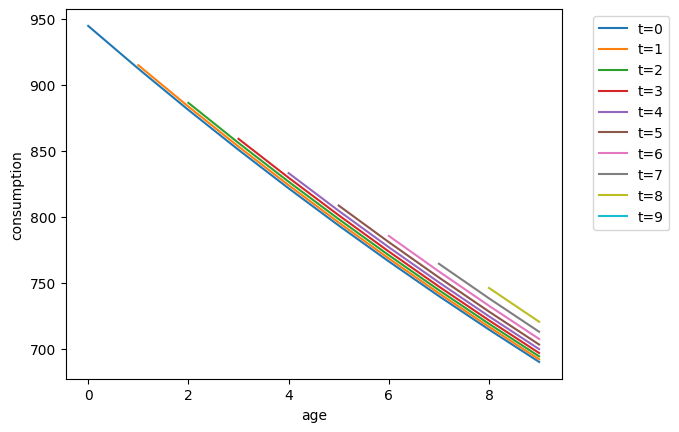

In [424]:
# Solve the model in forward-looking method
# Given the existence of bequest utilty, this method can lead to dynamic inconsistency
# See Becker and Mulligan (1997)

life_forward = model.forwardSolver(**params)
income = get_income_process(init_income=1000)
life_forward.plan_over_life(income_process=income,init_wealth=1000)

# plot the planned consumption paths

for t in range(life_forward.death_age+1):
    subset = life_forward.life_plans[f'age_{t}']
    plt.plot(subset['age'],subset['consumption'],label=f't={t}')

plt.xlabel('age')
plt.ylabel('consumption')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [425]:
# Generate actual consumption paths using forward-looking method

def gen_forward_paths(init_wealth,init_income,income_shock):

    all_paths = {}
    
    income = get_income_process(init_income)
    life_forward = model.forwardSolver(**params)

    # original path
    plan_path = life_forward.opt_life_path(income,init_wealth)

    print('original path')

    life_path = {'age':[0],
                'consumption':[plan_path['consumption'][0]],
                'wealth':[plan_path['wealth'][0]]}

    for t in tqdm(range(1,life_forward.death_age+1)):
        new_income = income[t:]
        new_init_wealth = life_path['wealth'][-1]
        plan_path = life_forward.opt_life_path(new_income,new_init_wealth)

        life_path['age'] += [t]
        life_path['consumption'] += [plan_path['consumption'][0]]
        life_path['wealth'] += [plan_path['wealth'][0]]
    
    all_paths['original'] = life_path

    # new paths
    shock_gain = [i[0] for i in income_shock]
    shock_t = [i[1] for i in income_shock]

    for i in range(len(income_shock)):

        print('get money at t=',shock_t[i])

        all_paths[f'shock_at_{shock_t[i]}'] = {'age':[],
                                            'consumption':[],
                                            'wealth':[]}

        for t in tqdm(range(shock_t[i],life_forward.death_age+1)):
            new_income = income[t:]
            if t == shock_t[i]:
                new_income[0] += shock_gain[i]
            
            new_init_wealth = life_path['wealth'][t-1]
            plan_path = life_forward.opt_life_path(new_income,new_init_wealth)

            all_paths[f'shock_at_{shock_t[i]}']['age'] += [t]
            all_paths[f'shock_at_{shock_t[i]}']['consumption'] += [plan_path['consumption'][0]]
            all_paths[f'shock_at_{shock_t[i]}']['wealth'] += [plan_path['wealth'][0]]

    return all_paths

In [426]:
forward_paths = []

for inc in income_levels:
    print('Solve the model for income level:', inc)
    init_wealth = inc
    init_income = inc
    income_shocks = [(inc,t) for t in shock_time]

    life_paths = gen_forward_paths(init_wealth,init_income,income_shocks)

    forward_paths += [life_paths]

Solve the model for income level: 100
original path


 11%|█         | 1/9 [00:05<00:45,  5.74s/it]h:\lifecycle_model\model.py:11: RuntimeWarning: divide by zero encountered in scalar power
  u = c**(1-kwargs['risk_coef']) / (1-kwargs['risk_coef'])
 22%|██▏       | 2/9 [00:10<00:36,  5.15s/it]h:\lifecycle_model\model.py:11: RuntimeWarning: divide by zero encountered in scalar power
  u = c**(1-kwargs['risk_coef']) / (1-kwargs['risk_coef'])
100%|██████████| 9/9 [00:24<00:00,  2.77s/it]


get money at t= 3


 14%|█▍        | 1/7 [00:03<00:23,  3.85s/it]h:\lifecycle_model\model.py:11: RuntimeWarning: divide by zero encountered in scalar power
  u = c**(1-kwargs['risk_coef']) / (1-kwargs['risk_coef'])
 29%|██▊       | 2/7 [00:07<00:17,  3.46s/it]h:\lifecycle_model\model.py:11: RuntimeWarning: divide by zero encountered in scalar power
  u = c**(1-kwargs['risk_coef']) / (1-kwargs['risk_coef'])
100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


get money at t= 5


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


get money at t= 7


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Solve the model for income level: 1000
original path


100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


get money at t= 3


100%|██████████| 7/7 [00:15<00:00,  2.14s/it]


get money at t= 5


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


get money at t= 7


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


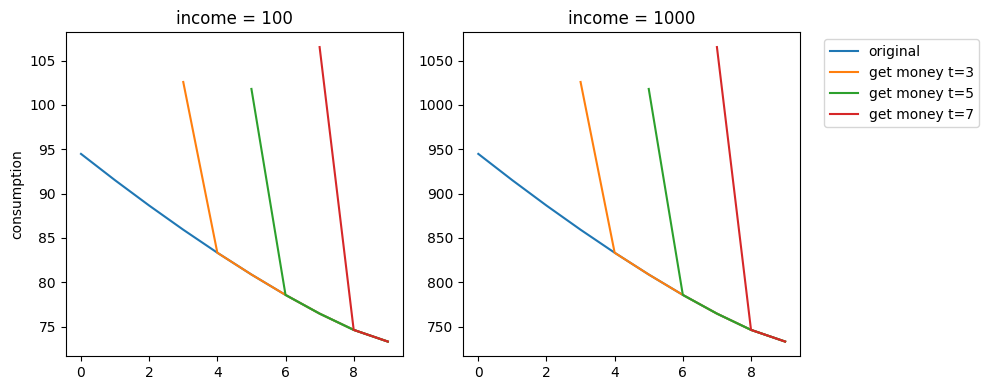

In [427]:
report_results.plot_paths(forward_paths,shock_time,income_levels,plot_name='consumption')

In [428]:
report_results.instant_consumption(forward_paths,shock_time,income_levels)

Instant increase in consumption when income shock happens
   shock_age  income=100  income=1000
0          3   16.658623   166.585845
1          5   20.927592   209.275562
2          7   30.057931   300.579519


In [517]:
# Generate actual consumption paths using backward induction

def gen_all_paths(init_wealth,init_income,income_shocks):

    all_paths = {}

    income = get_income_process(init_income)
    life_back = model.backwardSolver(**params)
    life_back.set_w_grid(init_wealth)

    print('original path')
    life_back.solve_consume_func(income)
    life_back.gen_life_path()

    all_paths['original'] = life_back.life_path

    for shock in income_shocks:
        shock_gain,shock_t = shock

        new_income = income.copy()[shock_t:]
        new_income[0] += shock_gain

        new_life_back = model.backwardSolver(**life_back.__dict__)
        new_life_back.consume_func_now(shock_t,new_income)
        new_life_back.income_process = np.concatenate((income[:shock_t], new_income))
        new_life_back.gen_life_path()

        all_paths[f'shock_at_{shock_t}'] = new_life_back.life_path

        print('get money at t=',shock_t)
    
    return all_paths


In [518]:
backward_paths = []

for inc in income_levels:
    print('Solve the model for income level:', inc)
    init_wealth = inc
    init_income = inc
    income_shocks = [(inc,t) for t in shock_time]

    life_paths = gen_all_paths(init_wealth,init_income,income_shocks)

    backward_paths += [life_paths]


Solve the model for income level: 100
original path
Final period is solved


100%|██████████| 9/9 [03:18<00:00, 22.06s/it]


get money at t= 3
get money at t= 5
get money at t= 7
Solve the model for income level: 1000
original path
Final period is solved


100%|██████████| 9/9 [09:11<00:00, 61.23s/it]


get money at t= 3
get money at t= 5
get money at t= 7


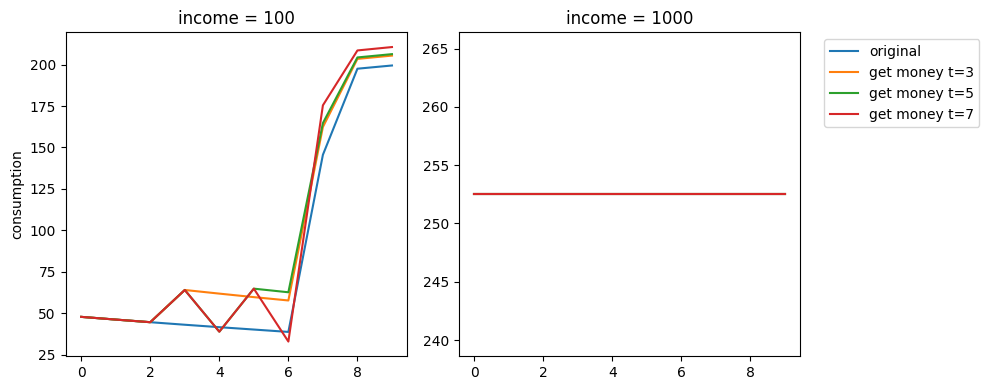

In [528]:
report_results.plot_paths(backward_paths,shock_time,income_levels,plot_name='consumption')

In [530]:
report_results.instant_consumption(backward_paths,shock_time,income_levels,forward=False)

Instant increase in consumption when income shock happens
   shock_age  income=100  income=1000
0          3   20.968967          0.0
1          5   24.665330          0.0
2          7   29.856754          0.0


In [547]:
# Save results
with open('forward_paths.json', 'w') as f:
    json.dump(forward_paths, f)


for i in range(len(backward_paths)):
    for key, value in backward_paths[i].items():
            value['income'] = value['income'].tolist()


with open('backward_paths.json', 'w') as f:
    json.dump(backward_paths, f)